# Scaleway - AI Inference Python demo

How to use:
- Execute cells with `SHIFT + ENTER``
- Make sure to execute cells in order (Executing previous cells might fails). 
- In case you want to reset the environment, use the menu "Kernel", "Restart Kernel and clear all outputs" and restart cells executionfrom the begining

## About AI Inference

Scaleway AI Inference provides clients with a flexible Machine Learning (ML) inference function which runs a trained model for clients on managed infrastructure and with built-in scalability.

By taking advantage of the serverless architecture, we provide:
- An adapted runtime for your model to perform fast predictions.
- A predictable billing that you pay only when predictions are made. The serveless function is only up when you call it.
- Auto-Scalability makes the inference server adapt to handle as much requests as you send it.The Scaleway Inference product provides clients with a flexible Machine Learning (ML) inference function which runs a trained model for clients on managed infrastructure and with built-in scalability.

By taking advantage of the serverless architecture, we provide:
- An adapted runtime for your model to perform fast predictions.
- A predictable billing that you pay only when predictions are made. The serveless function is only up when you call it.
- Auto-Scalability makes the inference server adapt to handle as much requests as you send it.


### About this demo
In this demo, you will be showned how to interact with the [Scaleway AI Inference API](https://developers.scaleway.com/en/products/inference/api/v1alpha1/) via Python.

In this demo, you will create an inference endpoint URL that you can query to make predictions with the [Squeezenet model](https://arxiv.org/abs/1602.07360https://arxiv.org/abs/1602.07360)

### About Squeezenet

We will download a pre-trained squeezenet model, exported as ONNX format and ready to use for inference (See [Squeezenet ONNX example](https://github.com/onnx/models/tree/master/vision/classification/squeezenet])).

SqueezeNet models perform image classification - they take images as input and classify the major object in the image into a set of pre-defined classes. They are trained on ImageNet dataset which contains images from 1000 classes. SqueezeNet models are highly efficient in terms of size and speed while providing good accuracies. This makes them ideal for platforms with strict constraints on size.

SqueezeNet is a small CNN which achieves AlexNet level accuracy on ImageNet with 50x fewer parameters. SqueezeNet requires less communication across servers during distributed training, less bandwidth to export a new model from the cloud to an autonomous car and more feasible to deploy on FPGAs and other hardware with limited memory.

Squeezenet 1.0 gives AlexNet level of accuracy with 50X fewer parameters. Run SqueezeNet 1.0 in browser - implemented by ONNX.js. SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters than SqueezeNet 1.0, without sacrificing accuracy.SqueezeNet models perform image classification - they take images as input and classify the major object in the image into a set of pre-defined classes. They are trained on ImageNet dataset which contains images from 1000 classes. SqueezeNet models are highly efficient in terms of size and speed while providing good accuracies. This makes them ideal for platforms with strict constraints on size.


## Install Python dependencies

In [1]:
%%bash

#pip install -q boto3


## Set your Scaleway credentials

This notebook will read your credentials from OS environment variables. If you have not setup your credentials yet, you can do it in the below cell (Change teh cell's type from from "Raw" ro "Code", enter your credentials, and execute the cell)

## Import and Validate the credentials

In [2]:
# Imports
import sys
import os
import json
import requests
import time
import base64
import datetime
from IPython.display import Image
import boto3


In [3]:
# Load credentials through environment variables and setup constants

# Get your credentials at https://console.scaleway.com/project/credentials
# For a new secret key, click on the button [Generate new API Key].
# More information about environment variables for Scaleway at
# https://github.com/scaleway/scaleway-sdk-go/tree/master/scw#environment-variables
environment_variable_keys = [
    "SCW_ACCESS_KEY",
    "SCW_SECRET_KEY",
    "SCW_DEFAULT_ORGANIZATION_ID",
    "SCW_DEFAULT_PROJECT_ID",
    "SCW_DEFAULT_REGION",
    "SCW_DEFAULT_ZONE",
    "SCW_API_URL",
    "SCW_ACCESS_KEY_S3",
    "SCW_SECRET_KEY_S3",
    "S3_BUCKET_NAME"
]

def hiden_secret(value):
    str_ = ""
    start = 0
    middle = min(8, int(len(value)/2))
    end = len(value)
    for i in range(start, middle):
        str_ += value[i]
    for i in range(middle, end):
        if value[i] == "-":
            str_ += "-"
        else:
            str_ += "✴"
    return str_

def print_environment_variable(key):
    if key in ["SCW_ACCESS_KEY", "SCW_SECRET_KEY", "SCW_DEFAULT_ORGANIZATION_ID", "SCW_DEFAULT_PROJECT_ID", "SCW_ACCESS_KEY_S3", "SCW_SECRET_KEY_S3"]:
        value = hiden_secret(os.getenv(key))
    else:
        value = os.getenv(key)
    print(f'  ${key}: {value}')

def assert_environment_variable(key):
    assert os.getenv(key) is not None, f"no value for environment variable ${key}"

def validate_environment_variables(environment_variable_keys):
    print('Validating environment variables')
    for key in environment_variable_keys:
        print_environment_variable(key)
        assert_environment_variable(key)

def validate_access_key(access_key):
    len_access_key = len(access_key)
    expected_len = 20
    assert len_access_key == expected_len, f"""invalid length for access key
        access key: {access_key[:8]}...
        expected length: {expected_len}
        length:          {len_access_key}"""

def validate_secret_key(secret_key):
    len_secret_key = len(secret_key)
    expected_len = 36
    assert len_secret_key == expected_len, f"""invalid length for secret key
        secret key: {secret_key[:8]}...
        expected length: {expected_len}
        length:          {len_secret_key}"""
        
validate_environment_variables(environment_variable_keys)

# If you prefer not to pass your credentials through environment variables, 
# you can overide the following constants directly.
SCW_ACCESS_KEY = os.getenv("SCW_ACCESS_KEY")
SCW_SECRET_KEY = os.getenv("SCW_SECRET_KEY")
SCW_DEFAULT_ORGANIZATION_ID = os.getenv("SCW_DEFAULT_ORGANIZATION_ID")
SCW_DEFAULT_PROJECT_ID = os.getenv("SCW_DEFAULT_PROJECT_ID")
SCW_DEFAULT_REGION = os.getenv("SCW_DEFAULT_REGION")
SCW_DEFAULT_ZONE = os.getenv("SCW_DEFAULT_ZONE")
SCW_API_URL = os.getenv("SCW_API_URL")
SCW_ACCESS_KEY_S3 = os.getenv("SCW_ACCESS_KEY_S3")
SCW_SECRET_KEY_S3 = os.getenv("SCW_SECRET_KEY_S3")

S3_BUCKET_NAME = os.getenv("S3_BUCKET_NAME")

validate_access_key(SCW_ACCESS_KEY)
validate_secret_key(SCW_SECRET_KEY)

MODEL_URL = "https://s3.amazonaws.com/onnx-model-zoo/squeezenet/squeezenet1.1/squeezenet1.1.onnx"

Validating environment variables
  $SCW_ACCESS_KEY: SCW73JGG✴✴✴✴✴✴✴✴✴✴✴✴
  $SCW_SECRET_KEY: dd631c2c-✴✴✴✴-✴✴✴✴-✴✴✴✴-✴✴✴✴✴✴✴✴✴✴✴✴
  $SCW_DEFAULT_ORGANIZATION_ID: 7c304503-✴✴✴✴-✴✴✴✴-✴✴✴✴-✴✴✴✴✴✴✴✴✴✴✴✴
  $SCW_DEFAULT_PROJECT_ID: 7c304503-✴✴✴✴-✴✴✴✴-✴✴✴✴-✴✴✴✴✴✴✴✴✴✴✴✴
  $SCW_DEFAULT_REGION: fr-par
  $SCW_DEFAULT_ZONE: fr-par-1
  $SCW_API_URL: https://api.scaleway.com
  $SCW_ACCESS_KEY_S3: SCW73JGG✴✴✴✴✴✴✴✴✴✴✴✴
  $SCW_SECRET_KEY_S3: dd631c2c-✴✴✴✴-✴✴✴✴-✴✴✴✴-✴✴✴✴✴✴✴✴✴✴✴✴
  $S3_BUCKET_NAME: inference-demo


## Make sure the inference API is up

This will be done by calling the API `https://api.scaleway.com/inference/v1alpha1`

You can directly call the API with `curl`:

```
curl -s -X GET  -H "X-Auth-Token: $SCW_SECRET_KEY" \
                -G -d "project_id=$SCW_DEFAULT_PROJECT_ID" \
                https://api.scaleway.com/inference/v1alpha1 | jq '.'
```

Or you can make the HTTP request via Python like in the code below:

In [4]:
# Make sure the inference API is up

def get_header(secret_key):
    return {
        "Content-Type": "application/json",
        "X-Auth-Token":  secret_key
    }

def api_inference_url(scw_api_url, inference_version):
    return f'{scw_api_url}/inference/{inference_version}'

def get_api_infos(scw_api_url, inference_version, secret_key):
    url = api_inference_url(scw_api_url, inference_version)
    headers = get_header(secret_key)
    response = requests.get(url, headers=headers)
    assert response.status_code == 200
    return response.json()


SCW_INFERENCE_VERSION = "v1alpha1"

print(f'Making sure Inference at Scale is up')

infos = get_api_infos(SCW_API_URL, SCW_INFERENCE_VERSION, SCW_SECRET_KEY)
print(f'inference api url: {api_inference_url(SCW_API_URL, SCW_INFERENCE_VERSION)}')
print(f'service information: {json.dumps(infos, indent=2)}')

Making sure Inference at Scale is up
inference api url: https://api.scaleway.com/inference/v1alpha1
service information: {
  "name": "Inference",
  "description": "Scaleway Inference At Scale API",
  "version": "1.0.21",
  "documentation_url": "https://developer.scaleway.com/"
}


## Make sure we are not over quotas

During the Early Access, each users can launch up to 10 model's inference endpoints. 

In the code below, if we are over quotas, you can decide to delete some models

You can directly call the API with `curl`:

```
curl -s -X GET  -H "X-Auth-Token: $SCW_SECRET_KEY" \
                -G -d "project_id=$SCW_DEFAULT_PROJECT_ID" \
                https://api.scaleway.com/inference/v1alpha1/models | jq '.'
```

Or you can make the HTTP request in the code below, using some Python helper functions:

In [5]:
# Make sure we are not over quotas

def get_api_infos(scw_api_url, inference_version, secret_key):
    url = api_inference_url(scw_api_url, inference_version)
    headers = get_header(secret_key)
    response = requests.get(url, headers=headers)
    assert response.status_code == 200
    return response.json()

def model_quotas():
    return 10

def list_models(scw_api_url, inference_version, secret_key, project_id):
    url = f'{scw_api_url}/inference/{inference_version}/models'
    headers = get_header(secret_key)
    payload = {
        "project_id": project_id,
        "page_size": 1000
    }
    response = requests.get(url, headers=headers, params=payload)
    assert response.status_code == 200, f"""can not list models
        status_code: {response.status_code}
        response: {response.json()}"""
    return response.json()['models'], response.json()['total_count']

print(f"getting models")
models, total_count = list_models(
    SCW_API_URL, 
    SCW_INFERENCE_VERSION, 
    SCW_SECRET_KEY,
    SCW_DEFAULT_PROJECT_ID)
print(f"existing models: {total_count}/{model_quotas()}")
for model in models:
    print(f"  {model['id']}: {model['name']}")
if total_count >= model_quotas():
    models_to_delete = total_count-model_quotas()+1
    print(f"To continue with the demo, you will have to delete {models_to_delete} model.")
    print(f'Set "MODELS_TO_DELETE = {models_to_delete}" in the next cell to do it.')
else:
    print(f"Enough quotas to continue with the demo.")

getting models
existing models: 1/10
  3f3e790c-7652-453c-acb0-3ebd87685ed7: iris.onnx
Enough quotas to continue with the demo.


In [6]:
# Optionally delete models if we are over quotas
MODELS_TO_DELETE = 0

def delete_model(model_id, scw_api_url, inference_version, secret_key):
    print(f'deleting model: {model_id}')
    url = f'{scw_api_url}/inference/{inference_version}/models/{model_id}'
    headers = get_header(secret_key)
    response = requests.delete(url, headers=headers)
    assert response.status_code == 200, f"""can not delete model
        model_id: {model_id}
        status_code: {response.status_code}
        response: {response.json()}"""
    model_info = response.json()
    print(f'status: {model_info["status"]}')
    return model_info

models_deleting_count = min(MODELS_TO_DELETE, len(models))
print(f'models: {total_count}')
print(f'deleting {models_deleting_count} models')
for i in range(models_deleting_count):
    try:
        delete_model(
            models[i]['id'],
            SCW_API_URL,
            SCW_INFERENCE_VERSION,
            SCW_SECRET_KEY)
    except Exception as exception:
        print(exception)

models: 1
deleting 0 models


### Create the model Inference endpoint

You can directly call the API with `curl`:

```
curl -s -X POST 'https://api.scaleway.com/inference/v1alpha1/models' \
                -H 'X-Auth-Token: <SCW_SECRET_KEY"> \
                -H 'Content-Type: application/json' \
                -d '{   "project_id": <SCW_DEFAULT_PROJECT_ID>",
    "name": "iris.onnx",
    "framework": "onnx:latest",
    "path": <MODEL_URL>,
    "config": {"input_type": "float32"}
}'

```

In [7]:
# Create a model and wait for its status to be "ready"
# We use https://s3.amazonaws.com/onnx-model-zoo/squeezenet/squeezenet1.1/squeezenet1.1.onnx

def onnx_model_creation_payload(project_id, s3_model_path, model_name):
    return {
        "project_id": project_id,
        "name": model_name,
        "framework": "onnx:latest",
        "path": s3_model_path,
        "config": {
            "input_type": "float32"
        }
    }

def create_model(scw_api_url, inference_version, secret_key, project_id, s3_model_path, model_name):
    url = f'{scw_api_url}/inference/{inference_version}/models'
    print(f"creating model at: {url}")
    headers = get_header(secret_key)
    payload = onnx_model_creation_payload(project_id, s3_model_path, model_name)
    response = requests.post(url, headers=headers, json=payload)
    assert response.status_code == 200, f"""could not create model
        status_code: {response.status_code}
        response: {response.json()}"""
    model = response.json()
    print(f'status: {model["status"]}')
    return model

def get_model(model_id, scw_api_url, inference_version, secret_key):
    url = f'{scw_api_url}/inference/{inference_version}/models/{model_id}'
    # print(f'getting model at: {url}')
    headers = get_header(secret_key)
    response = requests.get(url, headers=headers)
    assert response.status_code == 200, f"""can not get model
        model_id: {model_id}
        status_code: {response.status_code}
        response: {response.json()}"""
    return response.json()

def wait_for_status(
    model_id, expected_status, timeout, retry_interval, 
    scw_api_url, inference_version, secret_key
):
    print(f'waiting for status "{expected_status}"')
    max_retries = int(timeout/retry_interval)
    for retry in range(max_retries):
        model = get_model(model_id, scw_api_url, inference_version, secret_key)
        model_status_lower = model['status'].lower()
        print(f'status: {model_status_lower}')
        if model_status_lower == expected_status.lower():
            return model
        elif model_status_lower == "error":
            print("\nError while deploying the model: {}\n\n".format(model['error_message']))
            return
        else:
            print(f'waiting {retry_interval}s for status "{expected_status}" - {retry+1}/{max_retries}')
            time.sleep(retry_interval)
    raise Exception(f'timeout ({timeout}s) while waiting for status "{expected_status}"')


model = create_model(
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY, 
    SCW_DEFAULT_PROJECT_ID, 
    MODEL_URL,
    "ias_demo_1")
timeout = 20*60      # 20 minutes
retry_interval = 30  # 30 seconds
ready_model = wait_for_status(
    model['id'], 
    'ready', 
    timeout, 
    retry_interval,
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY
)
print(f"model is ready")
print(f"  id:       {ready_model['id']}")
print(f"  name:     {ready_model['name']}")
print(f"  status:   {ready_model['status']}")
print(f"  endpoint: {ready_model['endpoint']}")

creating model at: https://api.scaleway.com/inference/v1alpha1/models
status: converting
waiting for status "ready"
status: converting
waiting 30s for status "ready" - 1/40
status: building
waiting 30s for status "ready" - 2/40
status: building
waiting 30s for status "ready" - 3/40
status: deploying
waiting 30s for status "ready" - 4/40
status: deploying
waiting 30s for status "ready" - 5/40
status: deploying
waiting 30s for status "ready" - 6/40
status: ready
model is ready
  id:       eddcf2b2-b74f-48ae-bb92-c2421ed5901c
  name:     ias_demo_1
  status:   ready
  endpoint: https://inferenceatscaleprodbgq4euex-eddcf2b2-b74f-48ae-b.functions.fnc.fr-par.scw.cloud


### Make a prediction

In [8]:
# Now that our model is deployed and ready, we can finally use it to make a prediction !
# The model sqeezenet is used for image recognition.

def inference_payload(image_filename):
    with open(image_filename, "rb") as image_file:
        return {
            "data": {
                "format": "bin",
                "binData": {
                    "img_mode": "RGB",
                    "img_format": "channels_first",
                    "img_size": [
                        224,
                        224
                    ],
                    "values": base64.b64encode(image_file.read()).decode("utf-8")
                }
            }
        }

def get_predictions(endpoint, filename, verbose=False, raise_on_exception=True):
    if verbose:
        print(f'making inference for "{filename}" at {ready_model["endpoint"]}')
        print(f'this can take a few seconds')
    try:
        inference_results = requests.post(
            endpoint,
            json=inference_payload(filename))
        predictions = json.loads(inference_results.content)['data']['arrayData']['values']
    except Exception as exception:
        if raise_on_exception:
            raise Exception(f"cannot make prediction\n"
                            f"make sure enpoint is up\n"
                            f"endpoint: {endpoint}")
        else:
            print(f"cannot make prediction for {filename} at {endpoint}")
            predictions = []
    if verbose:
        print(f'ok')
    return predictions

IMAGE_FILENAME = 'image.png'

inference_results = get_predictions(
    ready_model['endpoint'], 
    IMAGE_FILENAME,
    verbose=True
)
print(f'results samples: {inference_results[:5]}')

making inference for "image.png" at https://inferenceatscaleprodbgq4euex-eddcf2b2-b74f-48ae-b.functions.fnc.fr-par.scw.cloud
this can take a few seconds
ok
results samples: [3.4068806171417236, 2.5719895362854004, 6.338659286499023, 8.104386329650879, 9.03067684173584]


In [9]:
# Now it's time to interpret our results.

def get_ImageNet_index_table():
    class_url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
    class_str = requests.get(class_url).content
    ImageNet_index = eval(class_str)
    return ImageNet_index

def pretty_float(f):
    return "%0.4f" % f

def print_interpreted_results(inference_results, limit):
    probabilities = sorted(inference_results, reverse=True)[:limit]
    probability_index = list(map(
        lambda x: inference_results.index(x),
        probabilities)
    )
    imagenet_index = get_ImageNet_index_table()
    print(f"{limit} first predictions ranked by probability:")
    for i in range(limit):
        index = probability_index[i]
        probability = inference_results[index]
        label = imagenet_index[index]
        print(f'  ({pretty_float(probability)}) {label}')

print_interpreted_results(inference_results, 5)

5 first predictions ranked by probability:
  (20.6558) dogsled, dog sled, dog sleigh
  (17.0380) Eskimo dog, husky
  (16.5538) malamute, malemute, Alaskan malamute
  (16.2119) Siberian husky
  (16.2076) Arabian camel, dromedary, Camelus dromedarius


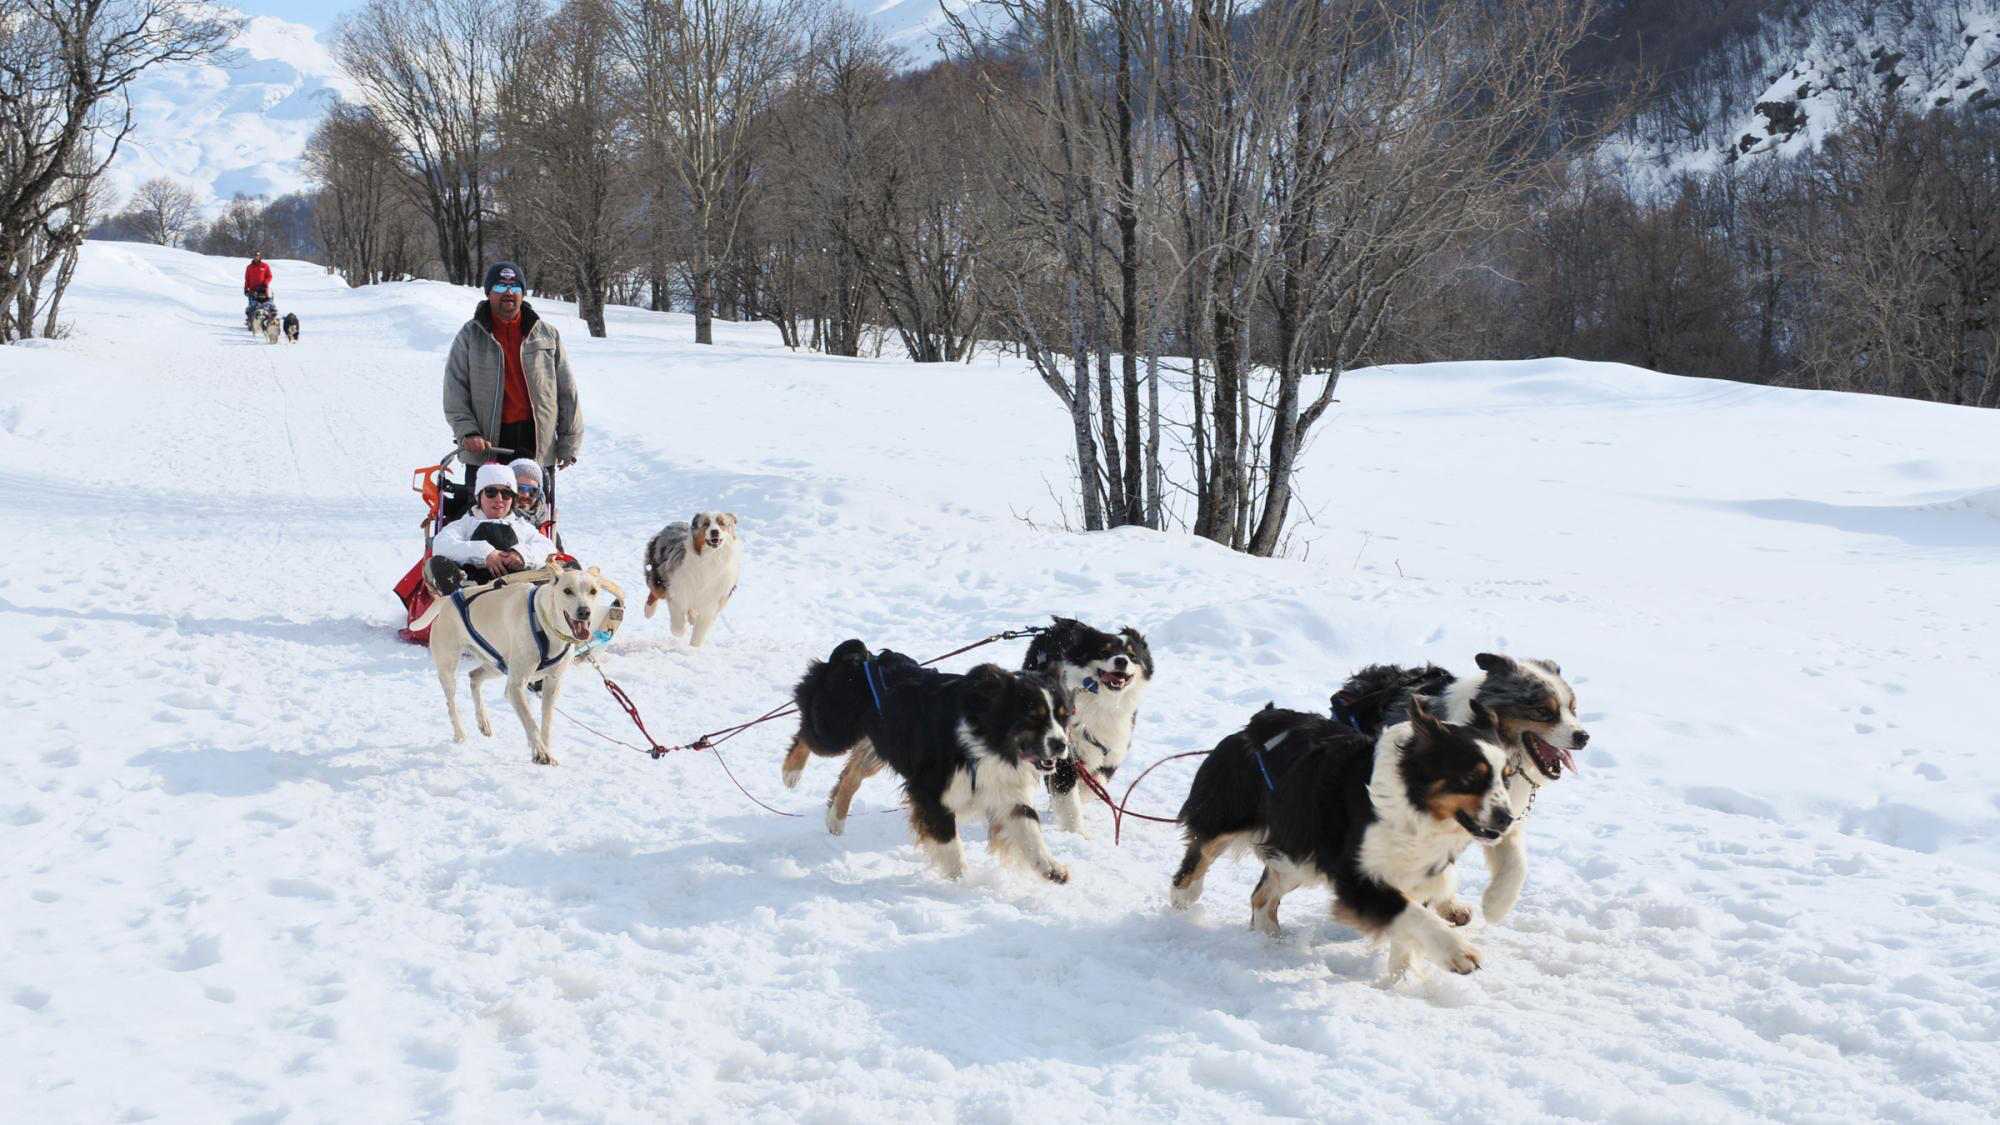

In [10]:
# Are our predictions correct ? 
# Let's find out !

# Display the image
Image(filename=IMAGE_FILENAME, width=int(2000/4), height=int(1125/4))

### Pause and Resume the Inference model

In [11]:
# Now that we're happy with our results,
# we can pause our model to save resources.
# This will delete the inference endpoint.

def pause_model(model_id, scw_api_url, inference_version, secret_key):
    url = f'{scw_api_url}/inference/{inference_version}/models/{model_id}/pause'
    model = get_model(
        model_id,
        scw_api_url,
        inference_version,
        secret_key)
    if model['status'].lower() != "paused":
        print(f'pausing model at: {url}')
        headers = get_header(secret_key)
        response = requests.post(url, headers=headers, json={})
        assert response.status_code == 200, f"""can not pause model
            model_id: {model_id}
            status_code: {response.status_code}
            response: {response.json()}"""
        return response.json()
    else:
        print(f'not pausing model: model is already paused')
        return model

model_id = pause_model(
    ready_model['id'],
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY)['id']
timeout = 10*60      # 10 minutes
retry_interval = 10  # 10 seconds
paused_model = wait_for_status(
    model_id, 
    'paused', 
    timeout, 
    retry_interval,
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY
)
print(f'endpoint: {paused_model["endpoint"]}')

pausing model at: https://api.scaleway.com/inference/v1alpha1/models/eddcf2b2-b74f-48ae-bb92-c2421ed5901c/pause
waiting for status "paused"
status: pausing
waiting 10s for status "paused" - 1/60
status: paused
endpoint: None


In [12]:
# We can also resume the model to make new predictions.

def resume_model(model_id, scw_api_url, inference_version, secret_key):
    url = f'{scw_api_url}/inference/{inference_version}/models/{model_id}/resume'
    model = get_model(
        model_id,
        scw_api_url,
        inference_version,
        secret_key)
    if model['status'].lower() != "ready":
        print(f'resuming model at: {url}')
        headers = get_header(secret_key)
        response = requests.post(url, headers=headers, json={})
        assert response.status_code == 200, f"""can not resume model
            model_id: {model_id}
            status_code: {response.status_code}
            response: {response.json()}"""
        return response.json()
    else:
        print(f'not resuming model: model is already ready')
        return model

model_id = resume_model(
    paused_model['id'],
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY)['id']
timeout = 20*60      # 20 minutes
retry_interval = 30  # 30 seconds
ready_model = wait_for_status(
    model_id,
    'ready',
    timeout,
    retry_interval,
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY
)
print(f'endpoint: {ready_model["endpoint"]}')

resuming model at: https://api.scaleway.com/inference/v1alpha1/models/eddcf2b2-b74f-48ae-bb92-c2421ed5901c/resume
waiting for status "ready"
status: deploying
waiting 30s for status "ready" - 1/40
status: deploying
waiting 30s for status "ready" - 2/40
status: deploying
waiting 30s for status "ready" - 3/40
status: deploying
waiting 30s for status "ready" - 4/40
status: ready
endpoint: https://inferenceatscaleprodbgq4euex-eddcf2b2-b74f-48ae-b.functions.fnc.fr-par.scw.cloud


### What if my model is not available on the internet yet ?

You can upload your local model to Scaleway Object Storage, and get its public url.

**Important** : The bucket name must be unique, so you have to customize it.

In [13]:
# First we setup some constants

#SCW_ACCESS_KEY_S3 = SCW_ACCESS_KEY
#SCW_SECRET_KEY_S3 = SCW_SECRET_KEY

S3_URL = f"https://s3.{SCW_DEFAULT_REGION}.scw.cloud"
#S3_BUCKET_NAME = f"scaleway-inference-demo"   # Customize the Bucket Name
S3_BUCKET_FILENAME = "squeezenet.onnx"
SCW_BUCKET_CONSOLE_BASE_URL = f"https://console.scaleway.com/object-storage/buckets"
SCW_BUCKET_CONSOLE_URL_TEMPLATE = f"{SCW_BUCKET_CONSOLE_BASE_URL}/{SCW_DEFAULT_REGION}/{{bucket_name}}/explorer"

validate_access_key(SCW_ACCESS_KEY_S3)
validate_secret_key(SCW_SECRET_KEY_S3)

In [14]:
# Then we download squeezenet locally in .onnx format
# This will be our local model

import requests
import hashlib

def md5(file_name):
    hash_md5 = hashlib.md5()
    with open(file_name, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def onnx_sqz_download_if_not_exist():
    model_name = "squeezenet.onnx"
    dl_url = "https://s3.amazonaws.com/onnx-model-zoo/squeezenet/squeezenet1.1/squeezenet1.1.onnx"
    md5_url = "https://s3.amazonaws.com/onnx-model-zoo/squeezenet/squeezenet1.1/squeezenet1.1-md5.txt"
    if os.path.exists(model_name):
        return os.path.abspath(model_name)
    print(f'downloading {model_name}')
    md5_sum = requests.get(md5_url).text
    with open(model_name, "wb") as file:
        sqz_rps = requests.get(dl_url)
        file.write(sqz_rps.content)
    assert md5_sum == md5(model_name)
    return os.path.abspath(model_name)

local_model_path = onnx_sqz_download_if_not_exist()
print(f'local_model_path: {local_model_path}')

local_model_path: /root/pycharm-remote/squeezenet.onnx


In [15]:
# Then we can upload our local model to Scaleway Object Storage (s3 bucket)

import sys
import boto3
from botocore.client import ClientError

def bucket_exists(bucket):
    try:
        resource.meta.client.head_bucket(Bucket=bucket.name)
        return True
    except ClientError:
        return False

def create_bucket_if_not_exist(bucket_name):
    bucket = resource.Bucket(bucket_name)
    if bucket_exists(bucket) == False:
        print(f'creating bucket')
        # The Access policy needs to be public for both Bucket and object
        bucket.create(ACL="public-read")
    else:
        print(f'bucket already exists: {bucket_name}')
    return bucket

def upload_file(bucket, model_path, s3_bucket_filename):
    client = resource.meta.client
    obj_list = client.list_objects(Bucket=bucket.name)
    
    if "Contents" not in obj_list.keys():
        print(f'uploading file: {s3_bucket_filename}')
        with open(model_path, "rb") as model_file:
            bucket.upload_fileobj(model_file, s3_bucket_filename, ExtraArgs={'ACL':'public-read'})
    else:
        obj_key = [ key["Key"] for key in client.list_objects(Bucket=bucket.name)["Contents"] ]
        if s3_bucket_filename not in obj_key:
            print(f'uploading file: {s3_bucket_filename}')
            with open(model_path, "rb") as model_file:
                bucket.upload_fileobj(model_file, s3_bucket_filename, ExtraArgs={'ACL':'public-read'})
        else:
            print(f'file already exists: {s3_bucket_filename}')
    
    return f"{bucket.name}/{s3_bucket_filename}"

s3_session = boto3.Session(region_name=SCW_DEFAULT_REGION)
resource = s3_session.resource("s3",
    endpoint_url=S3_URL,
    aws_access_key_id=SCW_ACCESS_KEY_S3,
    aws_secret_access_key=SCW_SECRET_KEY_S3
)

bucket = create_bucket_if_not_exist(S3_BUCKET_NAME)
s3_model_path = upload_file(bucket, local_model_path, S3_BUCKET_FILENAME)
print(f's3_model_path:            {s3_model_path}')
object_storage_model_url = f'{S3_URL}/{s3_model_path}'
print(f'object_storage_model_url: {object_storage_model_url}')
print(f'console link:             {SCW_BUCKET_CONSOLE_URL_TEMPLATE.format(bucket_name=bucket.name)}')

bucket already exists: inference-demo
uploading file: squeezenet.onnx
s3_model_path:            inference-demo/squeezenet.onnx
object_storage_model_url: https://s3.fr-par.scw.cloud/inference-demo/squeezenet.onnx
console link:             https://console.scaleway.com/object-storage/buckets/fr-par/inference-demo/explorer


In [16]:
# We create a new model, using the `object_storage_model_url` 

model = create_model(
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY, 
    SCW_DEFAULT_PROJECT_ID, 
    object_storage_model_url,
    "ias_demo_2")

timeout = 20*60      # 20 minutes
retry_interval = 30  # 30 seconds
ready_model_2 = wait_for_status(
    model['id'], 
    'ready', 
    timeout, 
    retry_interval,
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY
)
print(f"model is ready")
print(f"  id:       {ready_model['id']}")
print(f"  status:   {ready_model['status']}")
print(f"  endpoint: {ready_model['endpoint']}")

creating model at: https://api.scaleway.com/inference/v1alpha1/models
status: converting
waiting for status "ready"
status: converting
waiting 30s for status "ready" - 1/40
status: building
waiting 30s for status "ready" - 2/40
status: building
waiting 30s for status "ready" - 3/40
status: deploying
waiting 30s for status "ready" - 4/40
status: deploying
waiting 30s for status "ready" - 5/40
status: deploying
waiting 30s for status "ready" - 6/40
status: deploying
waiting 30s for status "ready" - 7/40
status: deploying
waiting 30s for status "ready" - 8/40
status: deploying
waiting 30s for status "ready" - 9/40
status: deploying
waiting 30s for status "ready" - 10/40
status: deploying
waiting 30s for status "ready" - 11/40
status: ready
model is ready
  id:       eddcf2b2-b74f-48ae-bb92-c2421ed5901c
  status:   ready
  endpoint: https://inferenceatscaleprodbgq4euex-eddcf2b2-b74f-48ae-b.functions.fnc.fr-par.scw.cloud


In [17]:
# We can see that we now have 2 models "ias_demo"

print(f"getting models")
models, total_count = list_models(
    SCW_API_URL, 
    SCW_INFERENCE_VERSION, 
    SCW_SECRET_KEY,
    SCW_DEFAULT_PROJECT_ID)
print(f"existing models: {total_count}/{model_quotas()}")
for model in models:
    print(f"  {model['id']}: {model['name']}")

getting models
existing models: 3/10
  71069e7a-3301-47f0-bc74-ac67d19227e3: ias_demo_2
  eddcf2b2-b74f-48ae-bb92-c2421ed5901c: ias_demo_1
  3f3e790c-7652-453c-acb0-3ebd87685ed7: iris.onnx


In [18]:
# And we can use our 2nd model to make a prediction

inference_results = get_predictions(
    ready_model_2['endpoint'], 
    'image.png',
    verbose=True
)
print(f'results samples: {inference_results[:5]}')

making inference for "image.png" at https://inferenceatscaleprodbgq4euex-eddcf2b2-b74f-48ae-b.functions.fnc.fr-par.scw.cloud
this can take a few seconds
ok
results samples: [3.4068806171417236, 2.5719895362854004, 6.338659286499023, 8.104386329650879, 9.03067684173584]


## Cleanup

In [19]:
# After all our tests, we can delete the models

def total_model_count(scw_api_url, inference_version, secret_key, project_id):
    _models, total_count = list_models(scw_api_url, inference_version, secret_key, project_id)
    return total_count

def wait_for_model_deletion(
    model_id, timeout, retry_interval, 
    scw_api_url, inference_version, secret_key
):
    print(f'waiting for deletion')
    max_retries = int(timeout/retry_interval)
    for retry in range(max_retries):
        url = f'{scw_api_url}/inference/{inference_version}/models/{model_id}'
        headers = get_header(secret_key)
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            print(f'status: {response.json()["status"]}')
            print(f'waiting {retry_interval}s for deletion - {retry+1}/{max_retries}')
            time.sleep(retry_interval)
        elif response.status_code == 404:
            print(f'ok')
            return
        else:
            print(response.status_code)
            print(response.json())
            raise Exception(f'error while waiting for model deletion')
    raise Exception(f'timeout ({timeout}s) while waiting for status "{expected_status}"')


c = total_model_count(SCW_API_URL, SCW_INFERENCE_VERSION, SCW_SECRET_KEY, SCW_DEFAULT_PROJECT_ID)
print(f"existing models: {c}")

delete_model(
    ready_model['id'], 
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY)

delete_model(
    ready_model_2['id'], 
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY)

wait_for_model_deletion(
    ready_model['id'], 
    5*60,
    10,
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY)

wait_for_model_deletion(
    ready_model_2['id'], 
    5*60,
    10,
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY)

c = total_model_count(SCW_API_URL, SCW_INFERENCE_VERSION, SCW_SECRET_KEY, SCW_DEFAULT_PROJECT_ID)
print(f"existing models: {c}")

existing models: 3
deleting model: eddcf2b2-b74f-48ae-bb92-c2421ed5901c
status: deleting
deleting model: 71069e7a-3301-47f0-bc74-ac67d19227e3
status: deleting
waiting for deletion
status: deleting
waiting 10s for deletion - 1/30
ok
waiting for deletion
ok
existing models: 1
